<a href="https://colab.research.google.com/github/Matancoo/IML.HUJI/blob/main/PyTorch_Scheduler_Examples_v1_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.1.0
import types
import math
from bisect import bisect_right

import torch
import numpy as np
import matplotlib.pyplot as plt

_LRScheduler = torch.optim.lr_scheduler._LRScheduler

print(f'torch version : {torch.__version__}')


torch version : 1.1.0


In [ ]:
def plot_lr(lrs, line_interval=50):
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(lrs)), lrs, )
  plt.xticks(np.arange(0, len(lrs) + 1, line_interval))
  plt.vlines(range(0, len(lrs)+1, line_interval), 0, 0.1, "green", linestyles='dashed')     # hlines
  plt.show()
  
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [ ]:
model = torch.nn.Linear(10, 3)

# v1.1.0におけるStepLR, MultiStepLRのバグ
v1.1.0において、scheduler側からget_lrで学習率を取得すると、挙動がおかしくなりますが、optimizer側から学習率を取得すると期待通りの挙動をするので、学習自体には問題はおきません。

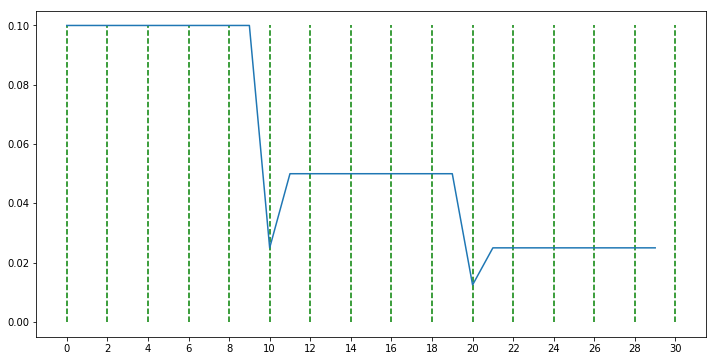

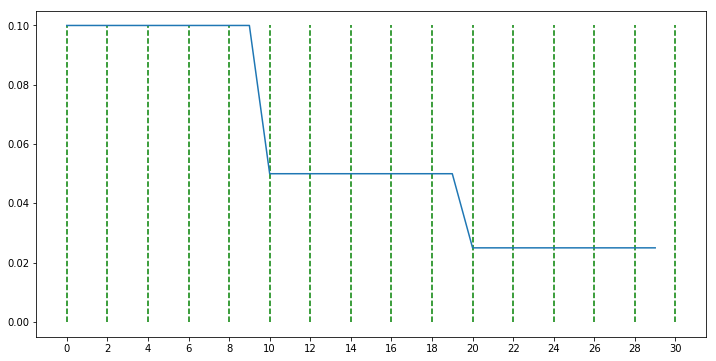

In [ ]:
#@title v1.1.0におけるStepLR, MultiStepLRのバグ
lrs_from_scheduler = list()
lrs_from_optim = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
for step in range(30):
  lrs_from_scheduler.append(scheduler.get_lr()[0])
  lrs_from_optim.append(get_lr(optimizer))
  scheduler.step()
plot_lr(lrs_from_scheduler, line_interval=2)
plot_lr(lrs_from_optim, line_interval=2)

## バグの修正

In [ ]:
class StepLR(_LRScheduler):
    """Sets the learning rate of each parameter group to the initial lr
    decayed by gamma every step_size epochs. When last_epoch=-1, sets
    initial lr as lr.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]


class MultiStepLR(_LRScheduler):
    """Set the learning rate of each parameter group to the initial lr decayed
    by gamma once the number of epoch reaches one of the milestones. When
    last_epoch=-1, sets initial lr as lr.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        milestones (list): List of epoch indices. Must be increasing.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 80
        >>> # lr = 0.0005   if epoch >= 80
        >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.milestones = milestones
        self.gamma = gamma
        super(MultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** bisect_right(self.milestones, self.last_epoch)
                for base_lr in self.base_lrs]

# PyTorchのschedulerの使用例

## [StepLR](https://github.com/pytorch/pytorch/blob/v1.0.1/torch/optim/lr_scheduler.py#L126)
---
引数一覧

- optimizer : 省略
- step_size : 何ステップごとに学習率を減少させるかの値
- gamma : 学習率の減少率
- last_epoch : 省略

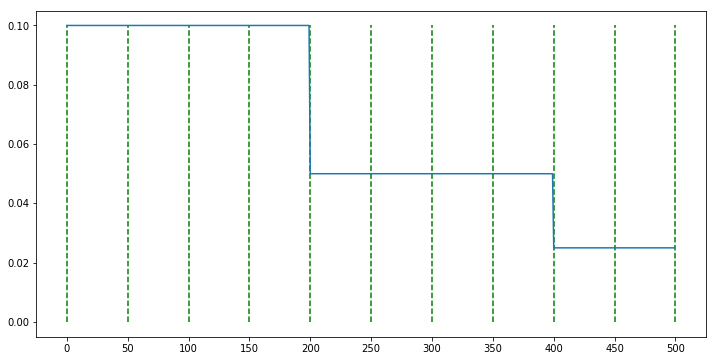

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

## [MultiStepLR](https://github.com/pytorch/pytorch/blob/v1.0.1/torch/optim/lr_scheduler.py#L161)
---
引数一覧

- optimizer : 省略
- milestones : 減少させたいstepのリスト
- gamma : 学習率の減少率
- last_epoch : 省略

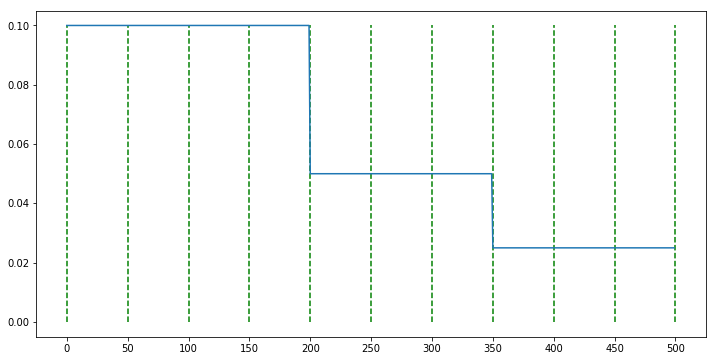

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = MultiStepLR(optimizer, milestones=[200, 350], gamma=0.5)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

## [LambdaLR](https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L56)
---
引数一覧

- optimizer : 省略
- lr_lambda : ラムダ式や関数を指定
- last_epoch : 省略


### ラムダ式を与えた場合

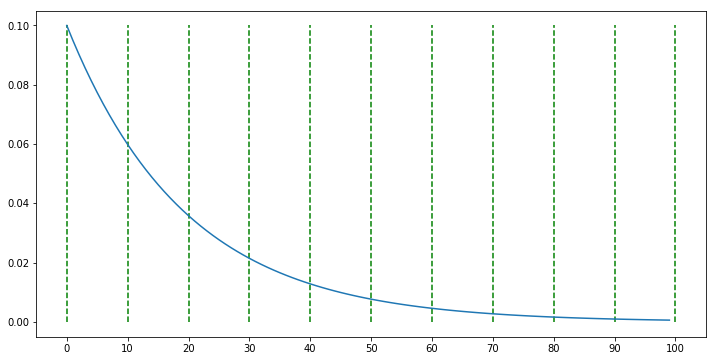

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)
for step in range(100):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs, line_interval=10)

### 関数を与えた場合

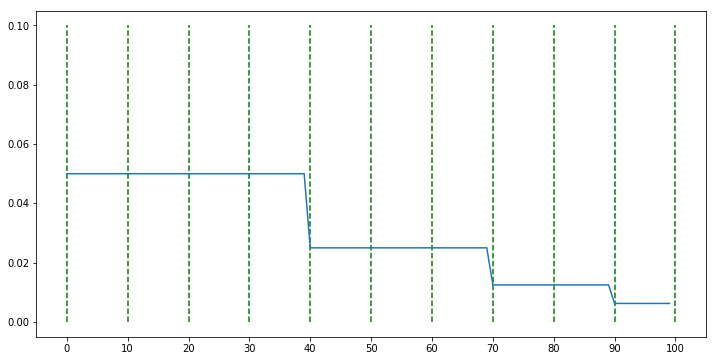

In [ ]:
def func(epoch):
    if epoch < 40:
        return 0.5
    elif epoch < 70:
        return 0.5**2
    elif epoch < 90:
        return 0.5**3
    else:
        return 0.5**4

lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = func)
for step in range(100):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs, line_interval=10)

### 継承を用いた場合

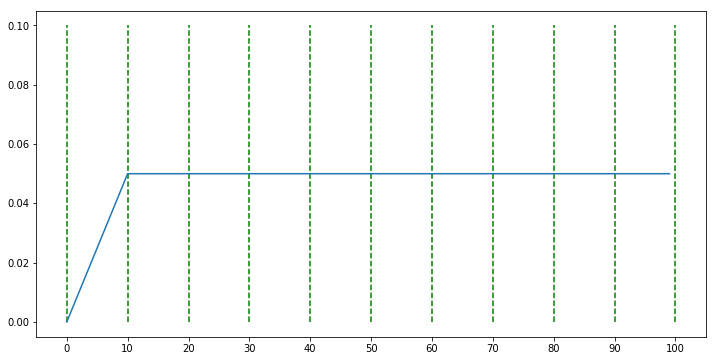

In [ ]:
class WarmupConstantSchedule(torch.optim.lr_scheduler.LambdaLR):
  # Reference : https://github.com/huggingface/pytorch-transformers/blob/master/pytorch_transformers/optimization.py#L33
    """ Linear warmup and then constant.
        Linearly increases learning rate schedule from 0 to 1 over `warmup_steps` training steps.
        Keeps learning rate schedule equal to 1. after warmup_steps.
    """
    def __init__(self, optimizer, warmup_steps, last_epoch=-1):

        def lr_lambda(step):
            if step < warmup_steps:
                return float(step) / float(max(1.0, warmup_steps))
            return 1.

        super(WarmupConstantSchedule, self).__init__(optimizer, lr_lambda, last_epoch=last_epoch)

lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-5)
scheduler = WarmupConstantSchedule(optimizer, warmup_steps=10)
for step in range(100):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs, line_interval=10)

## [ExponentialLR](https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L201)
---
引数一覧

- optimizer : 省略
- gamma : 学習率の減少率
- last_epoch : 省略

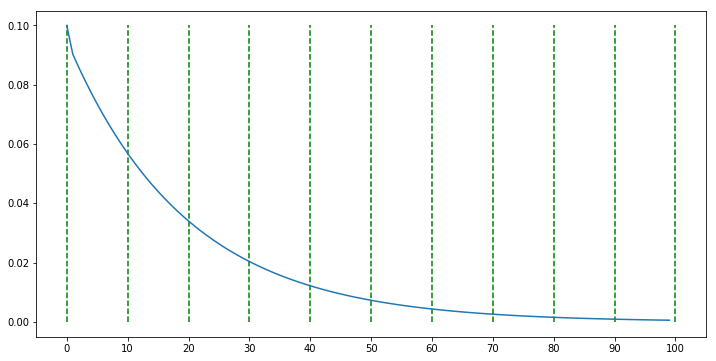

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
for step in range(100):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs, line_interval=10)

## [CosineAnnealingLR](https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L222)
---
引数一覧

- optimizer : 省略
- T_max : 半周期のステップサイズ
- eta_min : 下限学習率
- last_epoch : 省略

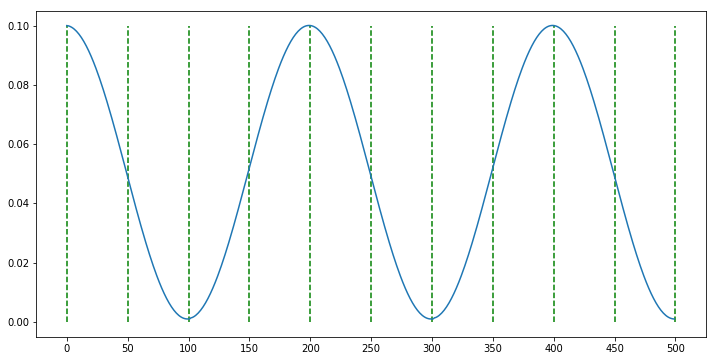

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

## [CyclicLR](https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L442)

引数一覧
- optimizer : 省略
- base_lr (float or list) : 下限学習率(初期値) 
- max_lr : 上限学習率
- step_size_up : 学習率上昇のサイクル数
- step_size_down : 学習率減少のサイクル数。Noneの時は、step_size_upと一致。
- mode : {"triangular", "triangular2", "exp_range"}から選択。`scale_fn`が`None`でなければ、無視される。
- gamma : modeが`'exp_range'`の場合の減少率
- scale_fn : 任意のスケールを満たしたい場合、関数(ラムダ式等)を渡す。渡した場合、`mode`は無視される。
- scale_mode : {'cycle', 'iterations'}から選択。`scale_fn`の引数がcycle数なのかiteration数なのかを決定。
- cycle_momentum : `True`ならば、`base_momentum`と`max_momentum`を逆に循環させる。また、`max_momentum`を初期値にする。
- base_momentum : 最適化関数におけるmomentumのサイクルの下限
- max_momentum : momentumのサイクルの上限
- last_epoch : 省略

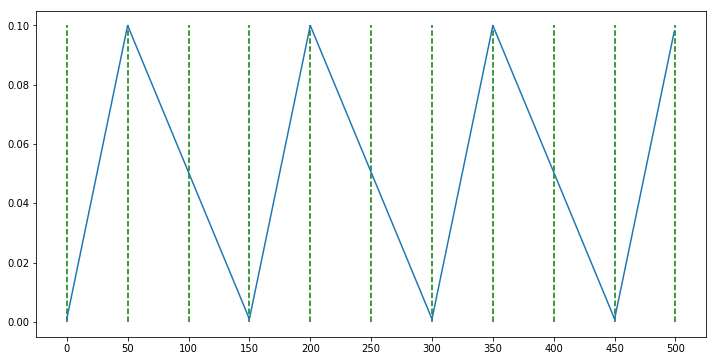

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,
                                                                             step_size_up=50, step_size_down=100, 
                                                                             mode='triangular')
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

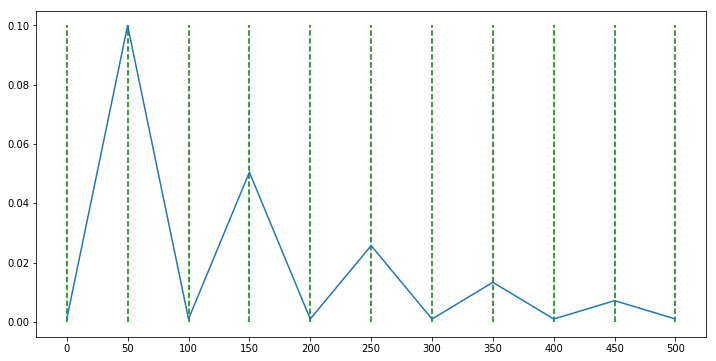

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,
                                                                             step_size_up=50, step_size_down=None, 
                                                                             mode='triangular2')
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

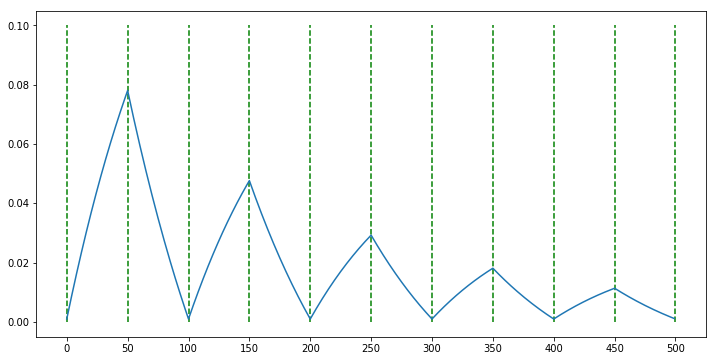

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,
                                                                             step_size_up=50, step_size_down=None, 
                                                                             mode='exp_range', gamma=0.995)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

## [CosineAnnealingWarmRestarts](https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L655)

引数一覧
- optimizer : 省略
- T_0 : 初期の繰りかえし回数
- T_mult : サイクルのスケール倍率
- eta_min : 下限学習率
- last_epoch : 省略

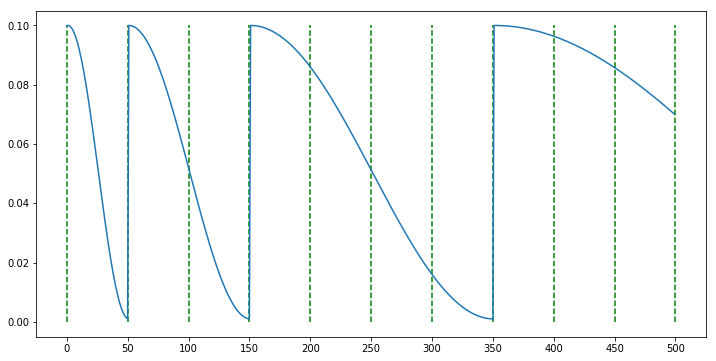

In [ ]:
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=0.001)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)

# Schedulerの自作
例としてWarmupありのSGDRを作成します。

In [ ]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            


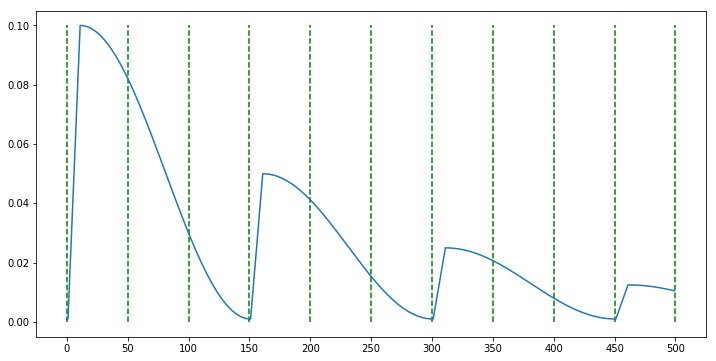

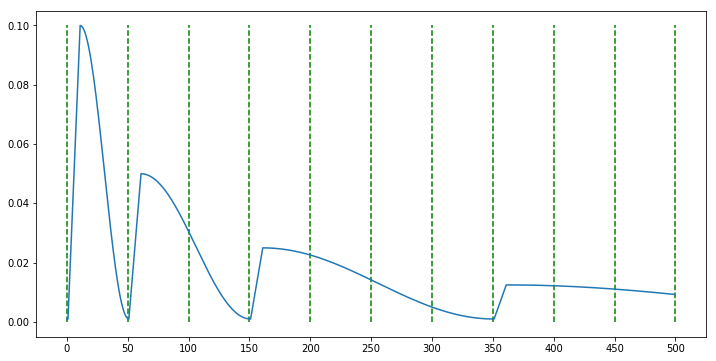

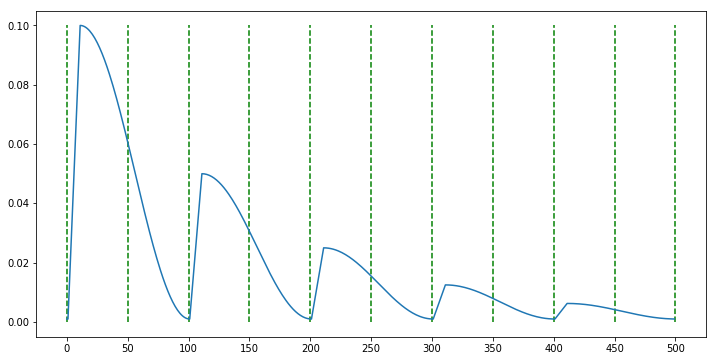

In [ ]:
# example 1
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step()
plot_lr(lrs)    

# example 2
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=2, eta_max=0.1,  T_up=10, gamma=0.5)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step(step)
plot_lr(lrs)

# example 3
lrs = list()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=100, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
for step in range(500):
  lrs.append(scheduler.get_lr()[0])
  scheduler.step(step)
plot_lr(lrs)